***
## IMPORTING THE REQUIRED LIBRARIES & DATA SET
***

In [42]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
#import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

# Educ tutorial 
#from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
#from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn import decomposition, ensemble

In [43]:
clothes_reviews = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [44]:
clothes_reviews

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


***
## EXPLORATORY DATA ANALYSIS & CLEANING
***

In [45]:
#drop rows with missing in reviews text
clothes_reviews=clothes_reviews.dropna(how='any',
                    subset=['Review Text'])

In [46]:
#define the plot size
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.0
4.0


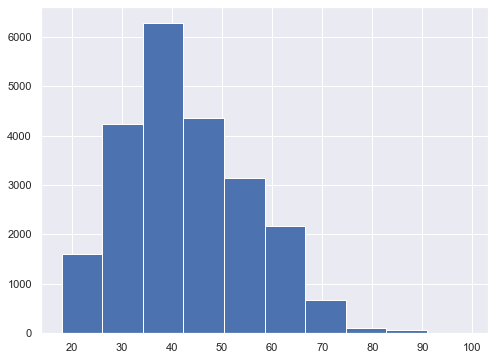

In [47]:
# To show the distrubution of reviews by Age
clothes_reviews['Age'].hist()

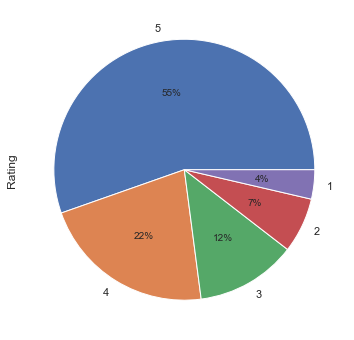

In [48]:
# Pie chart to depict the weight of each rating 
clothes_reviews.Rating.value_counts().plot(kind='pie', autopct='%1.0f%%')

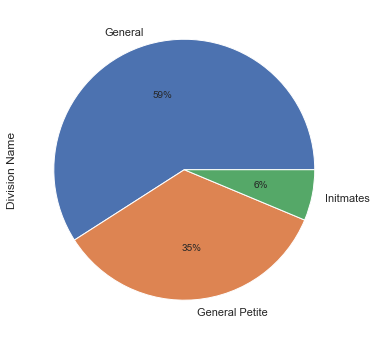

In [49]:
# Pie chart to depict the weight of each division
clothes_reviews['Division Name'].value_counts().plot(kind='pie', autopct='%1.0f%%')

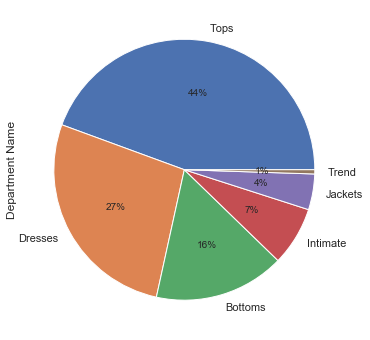

In [50]:
# Pie chart to depict the weight of each department
clothes_reviews['Department Name'].value_counts().plot(kind='pie', autopct='%1.0f%%')

AttributeError: 'AxesSubplot' object has no attribute 'get_xticketlabels'

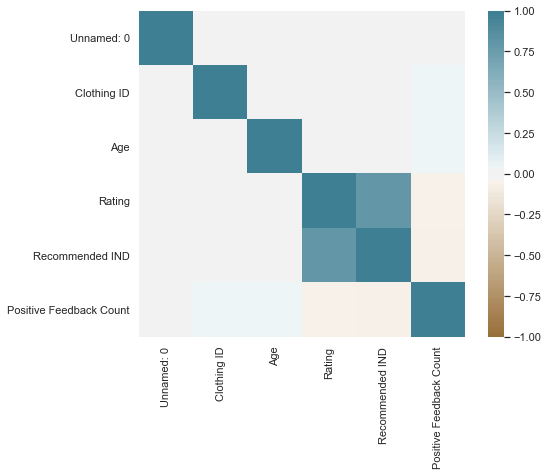

In [51]:
#correlation matrix 
corr = clothes_reviews.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(50,220,n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticketlabels(),
    rotation=45,
    horizontalalignment='right'
);

***
## TEXT FEATURES
***

In [52]:
# adding extra column to get the length of the review text
clothes_reviews['Review Length'] = clothes_reviews['Review Text'].map(lambda text: len(text))
clothes_reviews.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,500
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,124
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,192


In [53]:
# assign reviews with score > 3 as positive sentiment and scores < 3 as negative sentiment and neutral sentiment when = 3
clothes_reviews['Sentiment'] = clothes_reviews['Rating'].apply(lambda Rating : +1 if Rating > 3 else (0 if Rating == 3 else -1))

In [54]:
clothes_reviews.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length,Sentiment
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53,1
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303,1
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,500,0
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,124,1
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,192,1


In [55]:
text_feat = clothes_reviews[['Title','Review Text','Sentiment','Review Length']]
text_feat.head()

,Title,Review Text,Sentiment,Review Length
0,NaN,Absolutely wonderful - silky and sexy and comf...,1,53
1,NaN,Love this dress! it's sooo pretty. i happene...,1,303
2,Some major design flaws,I had such high hopes for this dress and reall...,0,500
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,124
4,Flattering shirt,This shirt is very flattering to all due to th...,1,192


In [56]:
text_feat['Review'] = text_feat['Title'] + ' ' + text_feat['Review Text']
text_feat = text_feat.drop(labels=['Title','Review Text'], axis =1)
text_feat.head()

,Sentiment,Review Length,Review
0,1,53,NaN
1,1,303,NaN
2,0,500,Some major design flaws I had such high hopes ...
3,1,124,"My favorite buy! I love, love, love this jumps..."
4,1,192,Flattering shirt This shirt is very flattering...


In [57]:
# dropping null values 
text_feat.Review.isna().sum()

2966

In [58]:
text_feat = text_feat[~text_feat.Review.isna()]
print("My data's shape is:", text_feat.shape)
text_feat.head()

My data's shape is: (19675, 3)


,Sentiment,Review Length,Review
2,0,500,Some major design flaws I had such high hopes ...
3,1,124,"My favorite buy! I love, love, love this jumps..."
4,1,192,Flattering shirt This shirt is very flattering...
5,-1,488,Not for the very petite I love tracy reese dre...
6,1,496,Cagrcoal shimmer fun I aded this in my basket ...


In [59]:
text_feat['Sentiment'].value_counts(normalize=True)

 1    0.770521
 0    0.125235
-1    0.104244
Name: Sentiment, dtype: float64

count    19675.000000
mean       318.353698
std        142.282429
min          9.000000
25%        199.000000
50%        315.000000
75%        475.000000
max        508.000000
Name: Review Length, dtype: float64

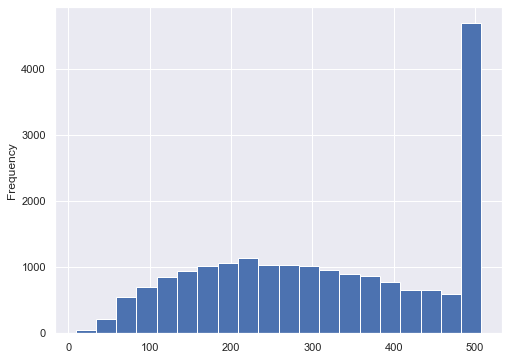

In [60]:
#plotting text length
text_feat['Review Length'].plot(bins=20, kind='hist')
text_feat['Review Length'].describe()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B212927DC8>,
      dtype=object)

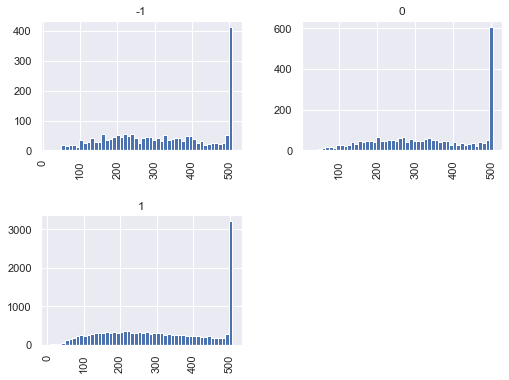

In [61]:
text_feat.hist(column='Review Length', by='Sentiment', bins=50)

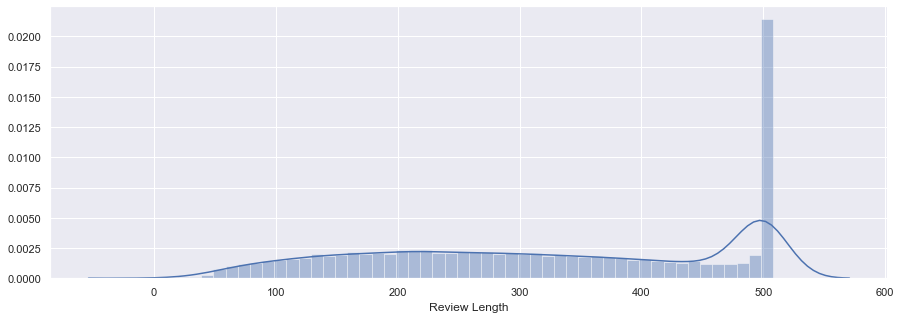

In [62]:
sns.set(rc={'figure.figsize':(15,5)})
sns.distplot(text_feat['Review Length'] ,hist=True, bins=50)

In [63]:
df_pos = text_feat[text_feat['Sentiment']==1]
df_neut = text_feat[text_feat['Sentiment']==0]
df_neg = text_feat[text_feat['Sentiment']==-1]

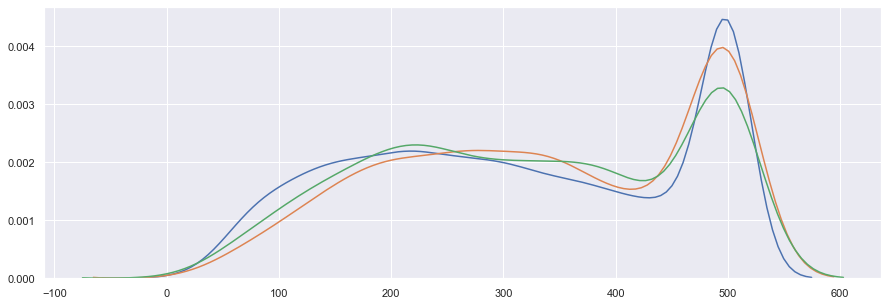

In [64]:
sns.distplot(df_pos[['Review Length']] ,hist=False)
sns.distplot(df_neut[['Review Length']], hist=False)
sns.distplot(df_neg[['Review Length']] ,hist=False)

def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

text_feat['Count Exc'] = text_feat['Review'].apply(count_exclamation_mark)
text_feat.head(5)

In [65]:
text_feat['Polarity'] = text_feat['Review'].apply(lambda Review: TextBlob(Review).sentiment.polarity)
text_feat.head(5)

,Sentiment,Review Length,Review,Polarity
2,0,500,Some major design flaws I had such high hopes ...,0.073209
3,1,124,"My favorite buy! I love, love, love this jumps...",0.560714
4,1,192,Flattering shirt This shirt is very flattering...,0.512891
5,-1,488,Not for the very petite I love tracy reese dre...,0.181111
6,1,496,Cagrcoal shimmer fun I aded this in my basket ...,0.157500


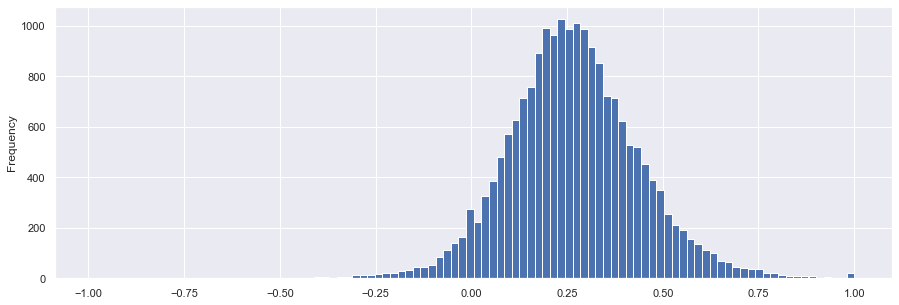

In [66]:
text_feat['Polarity'].plot(kind='hist', bins=100)

***

## DATA PREPROCESSING 

***

In [67]:
# all lower case
text_feat['Review']=text_feat['Review'].str.lower()

In [68]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
# removing punctuations 
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [70]:
text_feat['Review'] = text_feat['Review'].apply(punctuation_removal)
text_feat['Review'].head()

2    some major design flaws i had such high hopes ...
3    my favorite buy i love love love this jumpsuit...
4    flattering shirt this shirt is very flattering...
5    not for the very petite i love tracy reese dre...
6    cagrcoal shimmer fun i aded this in my basket ...
Name: Review, dtype: object

In [71]:
# part of speech tag 
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])  
    return ' '.join(new_string)

In [72]:
text_feat['Review'] = text_feat['Review'].apply(adj_collector)
text_feat['Review'].head(5)

2    major had such high wanted work i ordered smal...
3         favorite love love fabulous wear i get great
4    flattering is flattering due adjustable is per...
5    petite love reese is petite am tall wear was i...
6    aded last see look i went am pale is gorgeous ...
Name: Review, dtype: object

***
***

In [73]:
# removing stopwords
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [74]:
stop = stopwords.words('english')
stop.append("i'm")

In [75]:
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item)
print(stop_words[::10])

['i', 'youve', 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', 'shouldnt']


In [76]:
# adding to stopwords list 
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [77]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

# removing eights, size, and other numbers
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

text_feat['Review'] = text_feat['Review'].apply(drop_numbers)
text_feat['Review'].head()

In [78]:
# Removing frequent words
from collections import Counter
cnt = Counter()
for text in text_feat['Review'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('is', 27836),
 ('i', 16347),
 ('was', 11058),
 ('have', 7346),
 ('love', 7251),
 ('great', 7063),
 ('are', 6596),
 ('be', 6377),
 ('wear', 5389),
 ('am', 5189)]

In [79]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

text_feat['Review'] = text_feat['Review'].apply(lambda text: remove_freqwords(text))
text_feat.head()

,Sentiment,Review Length,Review,Polarity
2,0,500,major had such high wanted work ordered small ...,0.073209
3,1,124,favorite fabulous get,0.560714
4,1,192,flattering flattering due adjustable perfect p...,0.512891
5,-1,488,petite reese petite tall long full overwhelmed...,0.181111
6,1,496,aded last see look went pale gorgeous turns ma...,0.157500


In [80]:
# Drop the two columns which are no more needed 
#text_feat.drop(['text_stemmed','text_lemmatized','text_wo_stopfreq'], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

text_feat['Review'] = text_feat['Review'].apply(lambda text: remove_rarewords(text))
text_feat.head()

,Sentiment,Review Length,Review,Polarity
2,0,500,major had such high wanted work ordered small ...,0.073209
3,1,124,favorite fabulous get,0.560714
4,1,192,flattering flattering due adjustable perfect p...,0.512891
5,-1,488,petite reese petite tall long full overwhelmed...,0.181111
6,1,496,aded last see look went pale gorgeous turns ma...,0.157500


In [81]:
# stemming
from nltk.stem.porter import PorterStemmer

# Drop the two columns 
#text_feat.drop(["text_wo_stopfreq", "text_wo_stopfreqrare"], axis=1, inplace=True) 

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

text_feat['Review'] = text_feat['Review'].apply(lambda text: stem_words(text))
text_feat.head()

,Sentiment,Review Length,Review,Polarity
2,0,500,major had such high want work order small usua...,0.073209
3,1,124,favorit fabul get,0.560714
4,1,192,flatter flatter due adjust perfect pair cardigan,0.512891
5,-1,488,petit rees petit tall long full overwhelm smal...,0.181111
6,1,496,ade last see look went pale gorgeou turn mathc...,0.157500


In [82]:
# lammatizing 
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

text_feat['Review'] = text_feat['Review'].apply(lambda text: lemmatize_words(text))
text_feat.head()

,Sentiment,Review Length,Review,Polarity
2,0,500,major had such high want work order small usua...,0.073209
3,1,124,favorit fabul get,0.560714
4,1,192,flatter flatter due adjust perfect pair cardigan,0.512891
5,-1,488,petit rees petit tall long full overwhelm smal...,0.181111
6,1,496,ade last see look went pale gorgeou turn mathc...,0.157500


In [83]:
# WordCloud

In [84]:
pos_df = text_feat[text_feat.Sentiment== 1]
neut_df = text_feat[text_feat.Sentiment== 1]
neg_df = text_feat[text_feat.Sentiment== 0]
neut_df.head(5)

,Sentiment,Review Length,Review,Polarity
3,1,124,favorit fabul get,0.560714
4,1,192,flatter flatter due adjust perfect pair cardigan,0.512891
6,1,496,ade last see look went pale gorgeou turn mathc...,0.157500
7,1,482,goe order had tri use top pair went nice went ...,0.230342
8,1,166,flatter get run littl order flatter feminin usual,0.002500


In [85]:
pos_words =[]
neut_words=[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:30]

for review in neut_df.Review:
    neut_words.append(review) 
neut_words = ' '.join(neut_words)
neut_words[:30]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:100]

'major had such high want work order small usual found small small zip reorder petit ok overal top co'

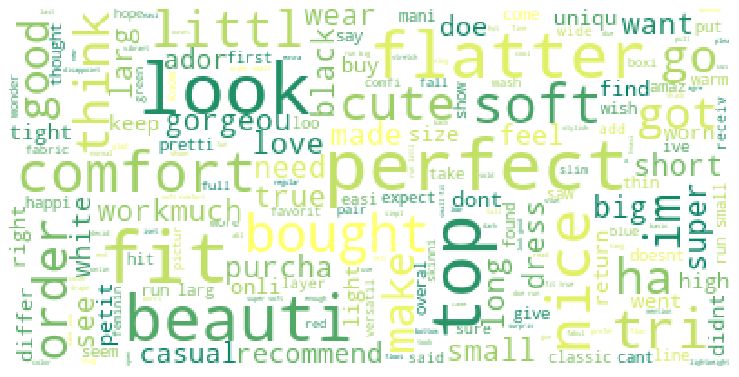

In [86]:
# wordcloud for positive sentiment

wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

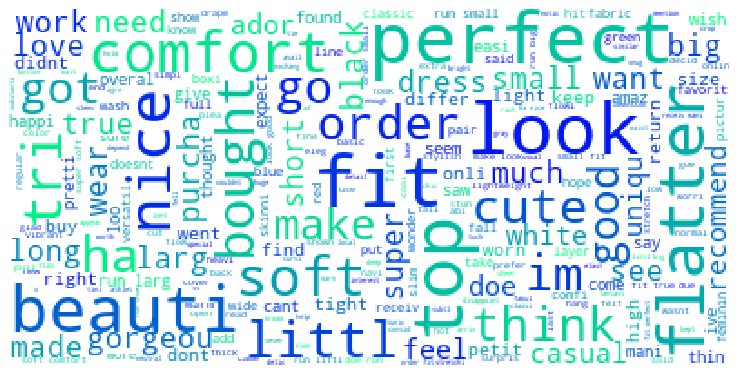

In [87]:
# wordcloud for neutral sentiment

wordcloud = WordCloud().generate(neut_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='winter').generate(neut_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

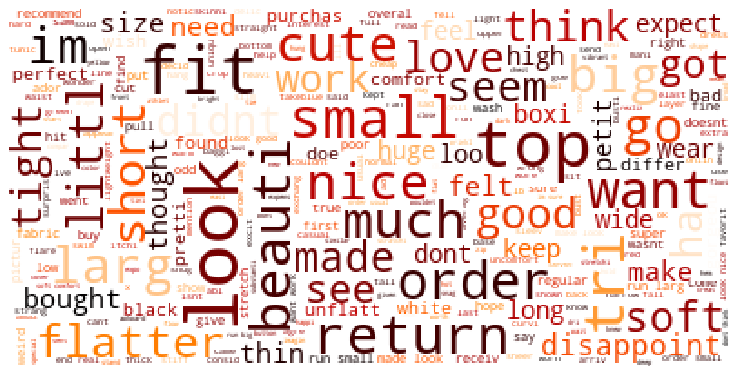

In [89]:
# wordcloud for negative sentiment
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [2]:
import anvil.server

In [3]:
anvil.server.connect("YESFY5MNJDDERL4GUEZUXFH4-MU4DV2L533AQVBHS")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [90]:
#vectorizing bag of words
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [91]:
bow_transformer = CountVectorizer(text_vectorizing_process)

In [92]:
bow_transformer.fit(text_feat['Review'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8',
                input=<function text_vectorizing_process at 0x000001B221774798>,
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [93]:
Reviews = bow_transformer.transform(text_feat['Review'])
Reviews

<19675x7409 sparse matrix of type '<class 'numpy.int64'>'
	with 260302 stored elements in Compressed Sparse Row format>

In [95]:
print('Shape of Sparse Matrix', Reviews.shape)
print('Amount of Non-Zero occurences:', Reviews.nnz)

Shape of Sparse Matrix (19675, 7409)
Amount of Non-Zero occurences: 260302


In [96]:
tfidf_transformer = TfidfTransformer().fit(Reviews)

In [97]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3510]

[('loft', 3510)]

In [99]:
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

[('order', 4305),
 ('comfort', 1191),
 ('get', 2554),
 ('full', 2475),
 ('look', 3544),
 ('decid', 1532)]

In [101]:
reviews_tfidf = tfidf_transformer.transform(Reviews)

In [102]:
reviews_tfidf = messages_tfidf.toarray()
reviews_tfidf = pd.DataFrame(reviews_tfidf)
print(reviews_tfidf.shape)
reviews_tfidf.head()

(19675, 7409)


,0,1,2,3,4,5,6,7,8,9,...,7399,7400,7401,7402,7403,7404,7405,7406,7407,7408
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.20611,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [103]:
text_feat_all = pd.merge(text_feat.drop(columns='Review'), reviews_tfidf, 
                  left_index=True, right_index=True )
text_feat_all.head()

,Sentiment,Review Length,Polarity,0,1,2,3,4,5,6,...,7399,7400,7401,7402,7403,7404,7405,7406,7407,7408
2,0,500,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,124,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,192,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-1,488,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,496,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
#Splitting the data
X = text_feat_all.drop('Sentiment', axis=1)
y = text_feat_all.Sentiment

X.head()

,Review Length,Polarity,0,1,2,3,4,5,6,7,...,7399,7400,7401,7402,7403,7404,7405,7406,7407,7408
2,500,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,124,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,192,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,488,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,496,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
X.describe()

,Review Length,Polarity,0,1,2,3,4,5,6,7,...,7399,7400,7401,7402,7403,7404,7405,7406,7407,7408
count,16481.000000,16481.000000,16481.000000,16481.0,16481.0,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,...,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000
mean,318.302834,0.265987,0.000023,0.0,0.0,0.000022,0.000022,0.000103,0.000052,0.000024,...,0.000022,0.000057,0.000074,0.000070,0.000050,0.000021,0.002029,0.000302,0.000030,0.000123
std,142.308680,0.172803,0.002964,0.0,0.0,0.002802,0.002879,0.006782,0.004788,0.003071,...,0.002843,0.005280,0.004819,0.005175,0.004512,0.002671,0.026215,0.010453,0.003801,0.007148
min,9.000000,-0.987500,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199.000000,0.158333,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,315.000000,0.260863,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,475.000000,0.370312,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,508.000000,1.000000,0.380549,0.0,0.0,0.359753,0.369649,0.541592,0.500109,0.394249,...,0.364975,0.560754,0.367715,0.403128,0.442586,0.342937,0.631888,0.476824,0.488008,0.499975


In [106]:
X_train, X_test, y_train, y_test = split(X,y, test_size=0.2, stratify=y, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13184, 7411), (3297, 7411), (13184,), (3297,))

In [107]:
y_train.value_counts(normalize=True)

 1    0.769645
 0    0.127124
-1    0.103231
Name: Sentiment, dtype: float64

In [108]:
y_test.value_counts(normalize=True)

 1    0.769791
 0    0.127085
-1    0.103124
Name: Sentiment, dtype: float64

In [109]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [110]:
# pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

In [111]:
pca_transformer = PCA(n_components=2).fit(X_train_scaled)
X_train_scaled_pca = pca_transformer.transform(X_train_scaled)
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
X_train_scaled_pca[:1]

array([[-0.27545987, -0.01901534]])

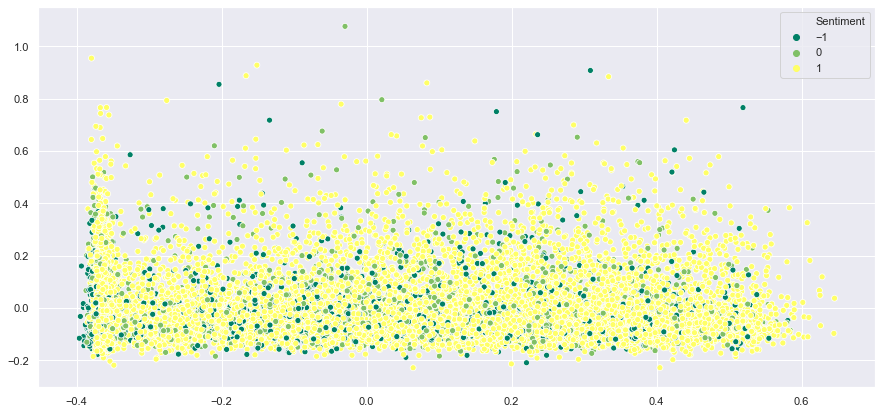

In [113]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_scaled_pca[:, 0], 
                y=X_train_scaled_pca[:, 1], 
                hue=y_train, 
                sizes=100,
                palette="summer") 

In [114]:
X_train_scaled = scipy.sparse.csr_matrix(X_train_scaled)
X_test_scaled = scipy.sparse.csr_matrix(X_test_scaled)

X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)
X_test

<3297x7411 sparse matrix of type '<class 'numpy.float64'>'
	with 50275 stored elements in Compressed Sparse Row format>

In [115]:
# Model
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

In [122]:
# SVM model
svc_model = SVC(C=1.0, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)
svc_model.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=111, shrinking=True, tol=0.001,
    verbose=False)

In [117]:
test_predictions = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions, svc_model.classes_ ))

Confusion Matrix:
     -1    0     1
-1  155  101    84
 0  141  120   158
 1  413  494  1631

Classification Report:
              precision    recall  f1-score   support

          -1       0.22      0.46      0.30       340
           0       0.17      0.29      0.21       419
           1       0.87      0.64      0.74      2538

    accuracy                           0.58      3297
   macro avg       0.42      0.46      0.42      3297
weighted avg       0.71      0.58      0.63      3297



In [119]:
import scikitplot as skplt

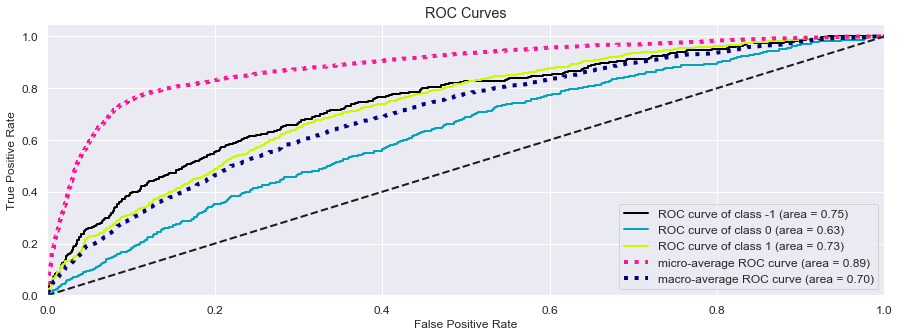

In [120]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_scaled)) 

In [123]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, 
                                  class_weight='balanced', random_state=3)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [124]:
test_predictions = rf_model.predict(X_test)
print(report(y_test, test_predictions, rf_model.classes_ ))

Confusion Matrix:
     -1    0     1
-1  188   72    80
 0  165   82   172
 1  387  220  1931

Classification Report:
              precision    recall  f1-score   support

          -1       0.25      0.55      0.35       340
           0       0.22      0.20      0.21       419
           1       0.88      0.76      0.82      2538

    accuracy                           0.67      3297
   macro avg       0.45      0.50      0.46      3297
weighted avg       0.73      0.67      0.69      3297



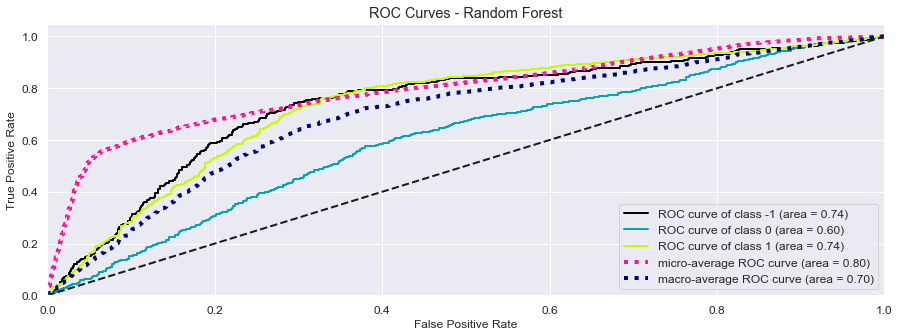

In [125]:
skplt.metrics.plot_roc(y_test, rf_model.predict_proba(X_test), 
                       title='ROC Curves - Random Forest') 